In [22]:
library(nlme)
library(multcomp)
options(jupyter.plot_mimetypes = "image/png")
library(ggplot2)
library(corrplot)
library(gridExtra)
library(grid)
library(data.table)
library(effects)
library(xtable)
library(reshape)

# Load Data

In [23]:
#stat_sum_single <- function(fun, geom="point", ...) {
#  stat_summary(fun.y=fun, colour="red", geom=geom, size = 3, ...)
#}

In [24]:
data = read.csv("../data_meta_analysis/Data_Classifications_v7.csv")

data<-data[c('PID','Info.type','Accuracy.50','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing','Coregistration','Pattern.normalization.type','Num_subs')]

factors<-c('Info.type','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing','Coregistration','Pattern.normalization.type','Num_subs')

R4 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_after_clustering2_2.csv"))

R4names = colnames(R4)
i=1
for (name in R4names){
    R4names[i]<-paste(sep='','R4',name)
    i=i+1
}
R4names
colnames(R4)<-R4names
head(R4)

[1] "R4Frontal_Sup" "R4Frontal_Mid" "R4Frontal_Inf" "R4Frontal_Orb"
[5] "R4Insula"      "R4Motor"       "R4Cingulum"

,R4Frontal_Sup,R4Frontal_Mid,R4Frontal_Inf,R4Frontal_Orb,R4Insula,R4Motor,R4Cingulum
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
5,1,0,0,0,0,0,0
6,1,0,0,0,0,0,0


In [25]:
nrow(R4)
nrow(data)

[1] 877

[1] 877

In [26]:
data = cbind(data,R4) # will bind with other region names too 


# mscl fixed 
data<-data[!data$Classifier.type=='neural-net',] # no observations but still has a level
data[data$Scanner=='4T','Scanner']='3T' # only one observatoin with 3T

data$PID<-as.factor(data$PID)
data$Info.type<-as.factor(data$Info.type)
data$Smoothing<-as.factor(data$Smoothing)
data$Roi.Search<-as.factor(data$Roi.Search)
data$Classifier.type<-as.factor(data$Classifier.type)
data$Coregistration<-as.factor(data$Coregistration)
data$Pattern.type<-as.factor(data$Pattern.type)
data$Pattern.normalization.type<-as.factor(data$Pattern.normalization.type)

# droplevels
data<-droplevels(data)

# sig / non sig split 
data_50<-subset(data,!is.na(Accuracy.50))
data_50_non<-subset(data,!is.na(Accuracy.50)& Significance==0)
data_50_sig<-subset(data,!is.na(Accuracy.50) & Significance==1)
head(data_50_sig)
nrow(data_50_sig)



,PID,Info.type,Accuracy.50,Significance,Roi.Search,Pattern.type,Classifier.type,Scanner,Smoothing,Coregistration,Pattern.normalization.type,Num_subs,R4Frontal_Sup,R4Frontal_Mid,R4Frontal_Inf,R4Frontal_Orb,R4Insula,R4Motor,R4Cingulum
2,93,Perceptual,0.52,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,1,0,0,0,0,0,0
3,93,Perceptual,0.52,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,1,0,0,0,0,0,0
4,93,Perceptual,0.52,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,1,0,0,0,0,0,0
5,93,Perceptual,0.52,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,1,0,0,0,0,0,0
6,93,Perceptual,0.525,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,1,0,0,0,0,0,0
7,93,Perceptual,0.53,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,1,0,0,0,0,0,0


[1] 506

In [27]:
#data[data$Info.type==levels(data$Info.type)[1],]
levels(data$Info.type)

[1] "Perceptual" "Response"   "Rule"       "Value"

# Just interaction model 

In [28]:
R1names_string<-c()
for (R in R4names){
    R1names_string<-paste(R1names_string,R,sep='+')
    
}
R1names_string<-substring(R1names_string, 2)
R1names_string

[1] "R4Frontal_Sup+R4Frontal_Mid+R4Frontal_Inf+R4Frontal_Orb+R4Insula+R4Motor+R4Cingulum"

In [29]:
d<-data_50_sig[c('Accuracy.50','PID','Info.type',R4names)]
gmean<-mean(d$Accuracy.50)
d$Accuracy.50_wo_gmean<-d$Accuracy.50-gmean
R1names_string2<-paste(R1names_string,')',sep='')
d$Info.type<-as.factor(d$Info.type)


In [30]:
# first model matrix # value as reference
d$Info.type=relevel(d$Info.type,ref='Value')
levels(d$Info.type)
region_model<-lme(as.formula(paste('Accuracy.50_wo_gmean~(',R1names_string2,'*Info.type',sep='')),random=~1|PID,data=d,method='REML')
X<-model.matrix(region_model,d)
X_interactions<-X[,12:ncol(X)]
#head(X_interactions)

[1] "Value"      "Perceptual" "Response"   "Rule"

In [31]:
# second one 
d$Info.type=relevel(d$Info.type,ref='Rule')
levels(d$Info.type)
region_model<-lme(as.formula(paste('Accuracy.50_wo_gmean~(',R1names_string2,'*Info.type',sep='')),random=~1|PID,data=d,method='REML')
X<-model.matrix(region_model,d)
X_interactions2<-X[,12:ncol(X)]
#head(X_interactions2)

[1] "Rule"       "Value"      "Perceptual" "Response"

In [32]:
#colnames(X_interactions2)
#colnames(X_interactions)

In [33]:

X_value<-X_interactions2[,c(1,4,7,10,13,16,19)]
X_perc<-X_interactions2[,c(2,5,8,11,14,17,20)]
X_resp<-X_interactions2[,c(3,6,9,12,15,18,21)]
X_rule<-X_interactions[,c(3,6,9,12,15,18,21)]
X_new<-data.frame(cbind(X_value,X_perc,X_resp,X_rule))
X_new<-as.matrix(X_new)


In [40]:
d<-data_50_sig[c('Accuracy.50','PID','Info.type',R4names)]
gmean<-mean(d$Accuracy.50)
d$Accuracy.50_wo_gmean<-d$Accuracy.50-gmean

region_model<-lme(Accuracy.50_wo_gmean~X_new,random=~1|PID,data=d,method='REML')
summary(region_model)$tTable

,Value,Std.Error,DF,t-value,p-value
(Intercept),-0.006004366,0.013915899,403.000000000,-0.431475257,0.666353565
X_newR4Frontal_Sup.Info.typeValue,2.838642e-03,1.665926e-02,4.030000e+02,1.703942e-01,8.647856e-01
X_newR4Frontal_Mid.Info.typeValue,-0.01300298,0.01853889,403.00000000,-0.70138968,0.48346468
X_newR4Frontal_Inf.Info.typeValue,-0.02237108,0.02359659,403.00000000,-0.94806416,0.34366494
X_newR4Frontal_Orb.Info.typeValue,0.01263054,0.02800135,403.00000000,0.45106904,0.65218240
X_newR4Insula.Info.typeValue,-0.01987325,0.05642054,403.00000000,-0.35223431,0.72484667
X_newR4Motor.Info.typeValue,-0.01670002,0.02374131,403.00000000,-0.70341624,0.48220257
X_newR4Cingulum.Info.typeValue,6.662075e-03,2.680151e-02,4.030000e+02,2.485709e-01,8.038193e-01
X_newR4Frontal_Sup.Info.typePerceptual,-0.01684198,0.01505933,403.00000000,-1.11837514,0.26407301
X_newR4Frontal_Mid.Info.typePerceptual,3.477833e-03,1.724333e-02,4.030000e+02,2.016915e-01,8.402597e-01


In [35]:

# get data #
s<-summary(region_model)
coef<-s$tTable[,1] 
se<-s$tTable[,2] 
df<-data.frame(cbind(coef,se))

df$name<-rownames(df)
df<-df[2:nrow(df),] # remove intercept

In [36]:
df$coef_gmean <- df$coef+gmean
df

,coef,se,name,coef_gmean
R4Frontal_Sup,-0.02006142,0.02195651,R4Frontal_Sup,0.5930668
R4Frontal_Mid,-0.02021323,0.01932778,R4Frontal_Mid,0.592915
R4Frontal_Inf,-0.01882218,0.02047211,R4Frontal_Inf,0.5943061
R4Frontal_Orb,-0.06014973,0.04185393,R4Frontal_Orb,0.5529785
R4Insula,-0.0307071,0.03113376,R4Insula,0.5824212
R4Motor,0.009676758,0.0212311,R4Motor,0.622805
R4Cingulum,-0.004906342,0.02399502,R4Cingulum,0.6082219
Info.typeValue,0.003774482,0.033813,Info.typeValue,0.6169027
Info.typePerceptual,-0.007285613,0.03106155,Info.typePerceptual,0.6058426
Info.typeResponse,-0.0763654,0.04834052,Info.typeResponse,0.5367629


In [37]:
# do some name changes for axis # 

cc<-c()
for (name in df$name){
    newname<-gsub("R4","",name)
    newname<-gsub("X_new","",newname)
    newname<-gsub("Info.type","",newname)
    newname<-gsub(".Rule"," (Rule)",newname)
    newname<-gsub(".Response"," (Response)",newname)
    newname<-gsub(".Perceptual"," (Perceptual)",newname)
    newname<-gsub(".Value"," (Value)",newname)
    newname<-gsub("Frontal_Sup","Superior frontal gyrus",newname)
    newname<-gsub("Frontal_Mid","Middle frontal gyrus",newname)
    newname<-gsub("Frontal_Inf","Inferior frontal gyrus",newname)
    newname<-gsub("Frontal_Orb","Superior & middle frontal gyrus, orbital part",newname)
    newname<-gsub("Insula","Insula",newname)
    newname<-gsub("Motor","Precentral gyrus & supplementary motory cortex",newname)
    newname<-gsub("Cingulum","Cingulate gyrus",newname)
    #newname<-gsub(".","_",newname)
    cc<-c(cc,newname)
    #print(newname)
    
}
df$name2<-cc

pdf 
  2

pdf 
  2

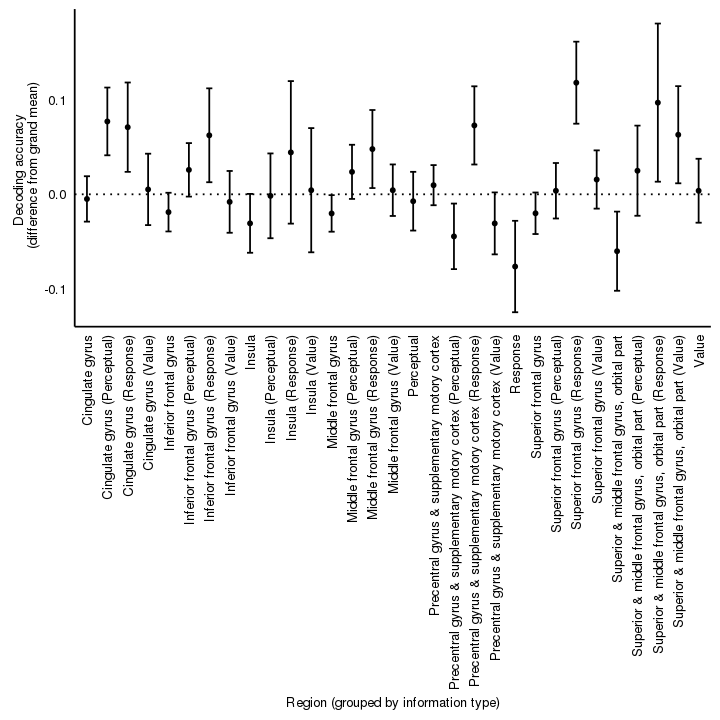

In [38]:



# main plot 
p<-ggplot(data=df,aes(x=name2))+
geom_point(aes(y=coef),size=1)+
geom_errorbar(aes(ymax = coef + se, ymin=coef- se),width=0.3)
p<-p+geom_hline(yintercept=0,linetype='dotted') 

mainlinewidth=.5
textsize = 8
labelsize = 8

# theme 
p<-p+xlab('Region (grouped by information type)')
p<-p+ylab('Decoding accuracy \n (difference from grand mean)')
p<-p+theme(panel.background=element_blank())


p<-p+theme(axis.line.x = element_line(color="black", size =mainlinewidth),
        axis.line.y = element_line(color="black", size = mainlinewidth))

p<-p+theme(axis.text.y = element_text(family="Helvetica",size=textsize,colour='black'))
p<-p+theme(axis.text.x = element_text(family="Helvetica",angle = 90, vjust=0.5,
                                      hjust = 1,size=textsize,colour='black'))
p<-p+theme(plot.title = element_text(family="Helvetica",size=labelsize,colour='black'))
p<-p+theme(axis.title.x = element_text(family="Helvetica",size=labelsize,colour='black'))
p<-p+theme(axis.title.y = element_text(family="Helvetica",size=labelsize,colour='black'))

p<-p+theme(axis.ticks.x=element_blank(),axis.ticks.y=element_blank())

setEPS()
postscript('../Figures/Supp_accuracy_by_region_info_interaction.eps',width=6,height=6)
p
dev.off()

png('../Figures/Supp_accuracy_by_region_info_interaction.png',width=6,height=6,
    units="in",res=400)
p
dev.off()
options(repr.plot.width=6, repr.plot.height=6)
p
